# Set up environment

In [1]:
#!wget https://www.dropbox.com/s/0c33f7sv6e8046k/sample_tax_form%20%281%29.zip
#!unzip "sample_tax_form (1).zip"

In [2]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.12/"
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

#import os
#os.environ['SPARK_OCR_LICENSE'] = license
#os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
#os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY

### Initialize Spark session

In [3]:
from sparkocr import start
import pkg_resources
from pyspark import SparkConf
from pyspark.ml import PipelineModel
import os

from sparkocr.transformers import *
from sparkocr.utils import display_images, display_table, display_tables
from sparkocr.enums import *

spark = start(jar_path = spark_ocr_jar_path)
spark

Spark version: 3.2.1
Spark NLP version: 4.2.4
Spark NLP for Healthcare version: 4.2.3
Spark OCR version: 4.3.0rc3



## Load test images

In [4]:
test_image_path = "data/pdfs/f1120.pdf"
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.select("path").show(truncate=False)

+--------------------------------------------------------------+
|path                                                          |
+--------------------------------------------------------------+
|file:/home/jose/spark-ocr/workshop/jupyter/data/pdfs/f1120.pdf|
+--------------------------------------------------------------+



In [5]:
pdf_to_hocr = PdfToHocr() \
    .setOutputCol("hocr")

tokenizer = HocrTokenizer() \
        .setInputCol("hocr") \
        .setOutputCol("token") \

pdf_to_image = PdfToImage() \
        .setInputCol("content") \
        .setOutputCol("image") \
        .setPageNumCol("tmp_pagenum") \
        .setImageType(ImageType.TYPE_3BYTE_BGR)

table_detector = ImageTableDetector \
        .pretrained("general_model_table_detection_v2", "en", "public/ocr/models") \
        .setInputCol("image") \
        .setOutputCol("table_regions") \
        .setScoreThreshold(0.9) \
        .setApplyCorrection(True) \
        .setScaleWidthToCol("width_dimension") \
        .setScaleHeightToCol("height_dimension")

image_scaler = ImageScaler() \
        .setWidthCol("width_dimension") \
        .setHeightCol("height_dimension")

hocr_to_table = HocrToTextTable() \
        .setInputCol("hocr") \
        .setRegionCol("table_regions") \
        .setOutputCol("tables")

draw_annotations = ImageDrawAnnotations() \
        .setInputCol("scaled_image") \
        .setInputChunksCol("tables") \
        .setOutputCol("image_with_annotations") \
        .setFilledRect(False) \
        .setFontSize(5) \
        .setRectColor(Color.red)

draw_regions = ImageDrawRegions() \
        .setInputCol("scaled_image") \
        .setInputRegionsCol("table_regions") \
        .setOutputCol("image_with_regions") \
        .setRectColor(Color.red)

pipeline1 = PipelineModel(stages=[
    pdf_to_hocr,
    tokenizer,
    pdf_to_image,
    table_detector,
    image_scaler,
    draw_regions,
    hocr_to_table,
    #draw_annotations,
])

result = pipeline1.transform(bin_df).cache().drop("tmp_pagenum")
result = result.filter(result.pagenum == 1)

display(result)

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB


path,modificationTime,length,hocr,height_dimension,width_dimension,pagenum,token,image,total_pages,documentnum,table_regions,scaled_image,image_with_regions,tables,exception,table_index
file:/home/jose/s...,2022-12-19 12:28:...,3471478,"<div title=""bbox ...",791,611,1,"[{token, 0, 2, 23...",{file:/home/jose/...,1,0,"{0, 0, 33.078854,...",{file:/home/jose/...,{file:/home/jose/...,"{{0, 0, 0.0, 0.0,...",null,0



    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/pdfs/f1120.pdf
    Resolution: 0 dpi
    Width: 611 px
    Height: 791 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


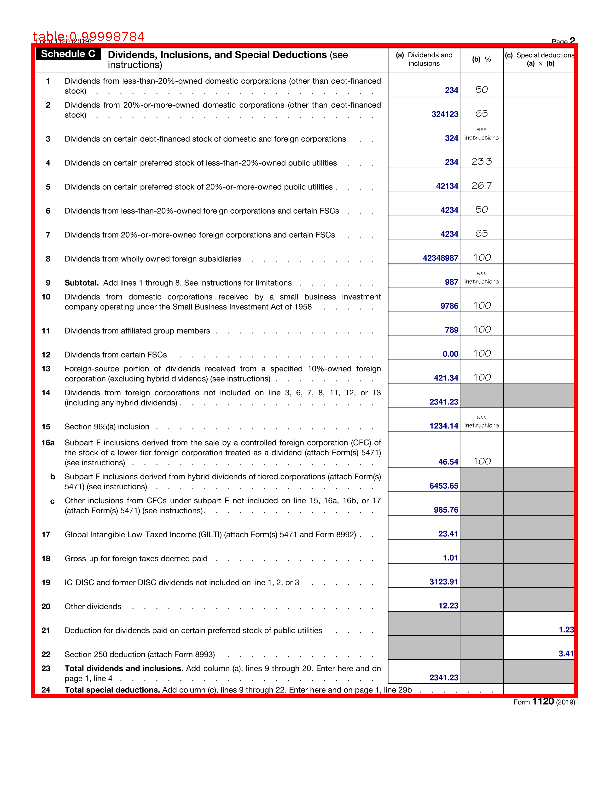

In [6]:
display_images(result, "image_with_regions", width=1000)

In [7]:
display_tables(result, table_col = "tables", table_index_col = "table_index")

Filename: f1120.pdf
Page:     1
Table:    0
5


,col0,col1,col2,col3,col4
0,Schedule C,"Dividends instructions , ) Inclusions , and Sp...",( a ) Dividends inclusions and,( b ) %,( c ) Special ( a ) × deductions ( b )
1,1,Dividends from less - than - 20 % - owned dome...,234,50,None
2,2,Dividends from 20 % - or - more - owned domest...,324123,65,None
3,3,Dividends on certain debt - financed stock of ...,324,instructions see,None
4,4,Dividends on certain preferred stock of less -...,234,23 . 3,None
5,5,Dividends on certain preferred stock of 20 % -...,42134,26 . 7,None
6,6,Dividends from less - than - 20 % - owned fore...,4234,50,None
7,7,Dividends from 20 % - or - more - owned foreig...,4234,65,None
8,8,Dividends from wholly owned foreign subsidiaries,42348987,100,None
9,9,Subtotal . Add lines 1 through 8 . See instruc...,987,instructions see,None


In [8]:
#display_images(result, "image_with_regions", width=1000)